In [10]:
!source .venv/bin/activate

In [11]:
from torchvision import datasets
import torch

data_folder = '/home/ramma/deep-learning/data/FMNIST' 
fmnist      = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images   = fmnist.data
tr_targets  = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

print('jumlah_data_image: ', len(tr_images), 'jumlah_data_targets: ', len(tr_targets))
device = "cuda" if torch.cuda.is_available() else "cpu"

jumlah_data_image:  60000 jumlah_data_targets:  60000


In [12]:
from torch.utils.data import Dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255       # converted the input into the floating-point number 
        x = x.view(-1,28*28)    # flattened each image into 28*28 = 748
        self.x, self.y = x, y 
    def __getitem__(self,  ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device),  y.to(device)
    def __len__(self):
        return len(self.x)

In [13]:
from torch.utils.data import DataLoader

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train,  batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

from torch.optim import SGD
import torch.nn as nn

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() #  cross entropy loss : loss calculation and activation function(softmax), It performs softmax internally. case multi class in ann we  not use softmax as activation function
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
     

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [14]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
     
    


In [15]:
import numpy as np

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

    print("EPOCH :", epoch, "|", "LOSSES :", train_losses[-1], "|", "ACCURACIES :", train_accuracies[-1])
    print("EPOCH :", epoch, "|", "LOSSES :", val_losses[-1], "|", "ACCURACIES :", val_accuracies[-1])

    

0
EPOCH : 0 | LOSSES : 0.8411360997041066 | ACCURACIES : 0.8032166666666667
EPOCH : 0 | LOSSES : 0.6046034693717957 | ACCURACIES : 0.7904
1
EPOCH : 1 | LOSSES : 0.5372928246815999 | ACCURACIES : 0.8274666666666667
EPOCH : 1 | LOSSES : 0.5278116464614868 | ACCURACIES : 0.8152
2
EPOCH : 2 | LOSSES : 0.4834371751467387 | ACCURACIES : 0.8330166666666666
EPOCH : 2 | LOSSES : 0.5057129859924316 | ACCURACIES : 0.8185
3
EPOCH : 3 | LOSSES : 0.4539172366579374 | ACCURACIES : 0.8494
EPOCH : 3 | LOSSES : 0.46925845742225647 | ACCURACIES : 0.8342
4
EPOCH : 4 | LOSSES : 0.43541513483524324 | ACCURACIES : 0.8505
EPOCH : 4 | LOSSES : 0.46415770053863525 | ACCURACIES : 0.8359


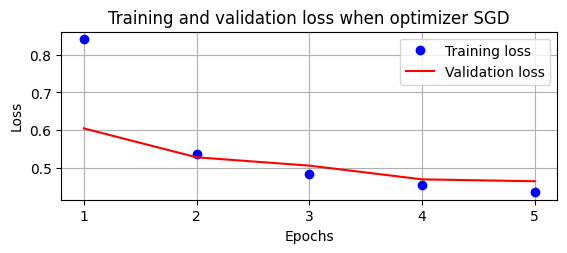

/tmp/ipykernel_10472/1207799301.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


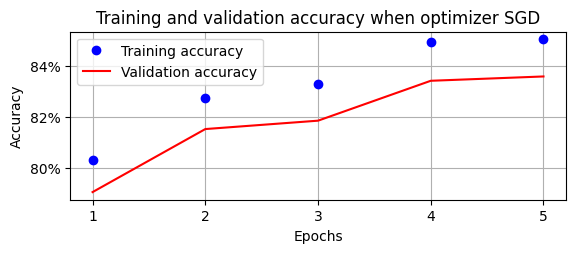

In [16]:
import matplotlib.pyplot as plt



epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when optimizer SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when optimizer SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [17]:
from torch.utils.data import DataLoader

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train,  batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

from torch.optim import SGD, Adam
import torch.nn as nn

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss() #  cross entropy loss : loss calculation and activation function(softmax), It performs softmax internally. case multi class in ann we  not use softmax as activation function
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
     

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()



In [18]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [19]:
import numpy as np

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

    print("EPOCH :", epoch, "|", "LOSSES :", train_losses[-1], "|", "ACCURACIES :", train_accuracies[-1])
    print("EPOCH :", epoch, "|", "LOSSES :", val_losses[-1], "|", "ACCURACIES :", val_accuracies[-1])

    

0
EPOCH : 0 | LOSSES : 0.540778172314167 | ACCURACIES : 0.8508666666666667
EPOCH : 0 | LOSSES : 0.48098236322402954 | ACCURACIES : 0.8367
1
EPOCH : 1 | LOSSES : 0.4339816568692525 | ACCURACIES : 0.84885
EPOCH : 1 | LOSSES : 0.4919503927230835 | ACCURACIES : 0.8316
2
EPOCH : 2 | LOSSES : 0.41037009967565535 | ACCURACIES : 0.8465166666666667
EPOCH : 2 | LOSSES : 0.5163455009460449 | ACCURACIES : 0.8296
3
EPOCH : 3 | LOSSES : 0.40587285956541697 | ACCURACIES : 0.8678
EPOCH : 3 | LOSSES : 0.4446433484554291 | ACCURACIES : 0.8482
4
EPOCH : 4 | LOSSES : 0.39374625531435015 | ACCURACIES : 0.8604833333333334
EPOCH : 4 | LOSSES : 0.46481552720069885 | ACCURACIES : 0.838


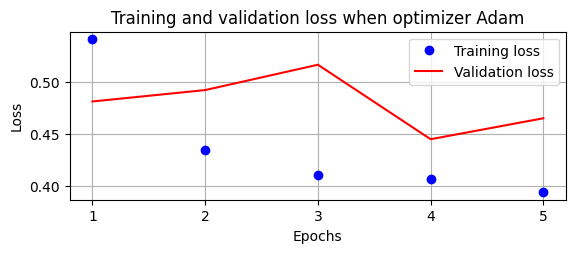

/tmp/ipykernel_10472/1976194820.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


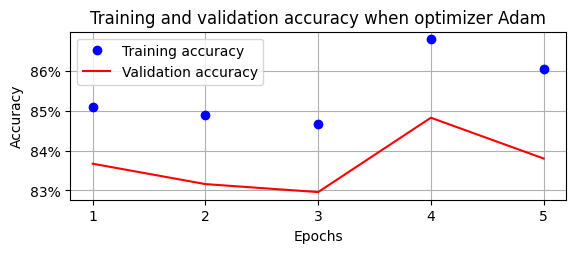

In [20]:
import matplotlib.pyplot as plt



epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when optimizer Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when optimizer Adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Adam Optimizer than SGD Optimizer. the conclusion  is Adam is more Agrresive than SGD.  it's mean SGD is more prone getting trap in local minimal. but we can not say Adam is better than SGD or etc. it's depend  on your case and luck